In [4]:
### Aidan Polivka PA.2

# you don't need to download the data, but you do need to decompress
# it! Decompress insurance.tgz and then load insurance.csv as a 
# Pandas datafrome. 

import os
import tarfile

# function to decompress insurance tgz file
def fetch_insurance_data():
    insurance_tgz = tarfile.open('insurance.tgz')
    insurance_tgz.extractall('.')
    insurance_tgz.close()
    
# call the function to extract data
fetch_insurance_data()

In [7]:
# look at the dataframe's metadata to see the types of the 
# columns, and if there is any data missing.

import pandas as pd

# function to load insurance data into a Pandas dataframe (assumes the prior code cell was executed)
def load_insurance_data():
    return pd.read_csv('insurance.csv')

#load the data
data = load_insurance_data()
data.head()              

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92
1,18,male,33.770,1,no,southeast,1725.55
2,28,male,33.000,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.47
4,32,male,28.880,0,no,northwest,3866.86


In [9]:
# look at the categorical fields; look at the sex field here
data['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [10]:
# now the smoker field
data['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [11]:
# now the region field
data['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [12]:
# examine the characteristics of the numerical fields
data.describe()

,age,bmi,children,charges
count,1338.000000,1323.000000,1338.000000,1338.000000
mean,39.207025,30.666017,1.094918,13270.422414
std,14.049960,6.088645,1.205493,12110.011240
min,18.000000,15.960000,0.000000,1121.870000
25%,27.000000,26.315000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.687500,2.000000,16639.915000
max,64.000000,53.130000,5.000000,63770.430000


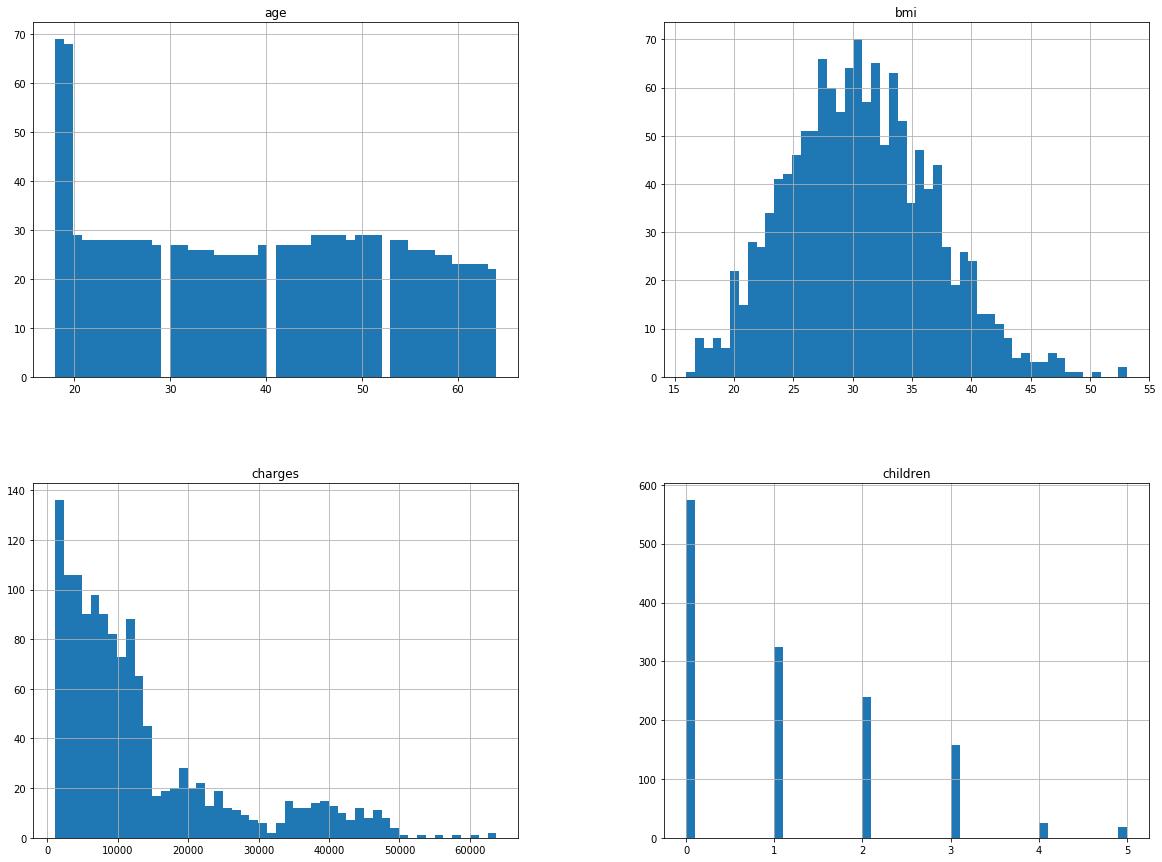

In [15]:
# do histograms of the numeric fields

# To display plots in Jupyter notebook
%matplotlib inline

import matplotlib.pyplot as plt

# create the histograms
data.hist(bins=50, figsize=(20,15))
plt.show()

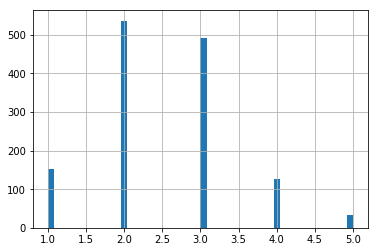

In [40]:
# create a 'bmi_cat' field in the data set, which puts the BMI values
# into five categories (1, 2, 3, 4, and 5). You will have to 'shift'
# the BMI values to the left, in addition to a division, because the
# minimum value is not zero.

import numpy as np

# Creat a categorized BMI column in the dataframe
data['bmi_cat'] = np.ceil((data['bmi']-15.95)*.135)
data['bmi_cat'].where(data['bmi_cat'] < 5, 5.0, inplace = True)

# Look at the categories via a histogram
data['bmi_cat'].hist(bins=50)
plt.show()


In [41]:
# create a training and testing set (80% / 20%) using StratifiedShuffleSplit,
# based on the 'bmi_cat' field you created. 

# Use a scikit-learn function to split the data
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["bmi_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [42]:
# look at the percent of values in each BMI category in the test set
strat_test_set['bmi_cat'].value_counts() / len(strat_test_set)

2.0    0.399254
3.0    0.365672
1.0    0.115672
4.0    0.097015
5.0    0.022388
Name: bmi_cat, dtype: float64

In [44]:
# ditto for the full data set; make sure the percentages are close

# compare to full data set to see if our test set seems representative
data['bmi_cat'].value_counts() / len(data)

2.0    0.400598
3.0    0.366966
1.0    0.113602
4.0    0.094918
5.0    0.023916
Name: bmi_cat, dtype: float64

In [46]:
# drop the 'bmi_cat' field from the training, test, and full dataframes

for set_ in (strat_train_set, strat_test_set):
    set_.drop('bmi_cat', axis = 1, inplace = True)

In [50]:
# make a copy of the training dataframe, and then examine the correlation
# coefficient between the charges attribute and the others
data = strat_train_set.copy()

#create correlational matrix
corr_matrix = data.corr()
corr_matrix['charges'].sort_values(ascending=False)

charges     1.000000
age         0.291195
bmi         0.176345
children    0.064313
Name: charges, dtype: float64

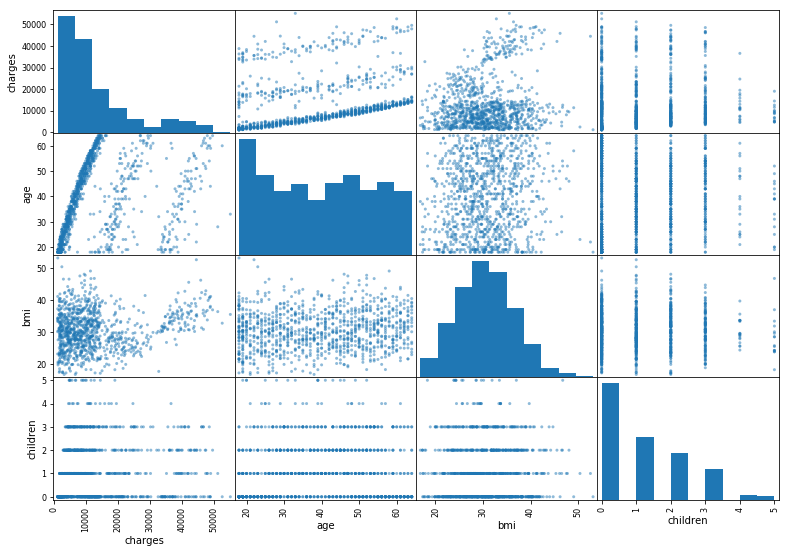

In [54]:
# look at the scatter matrices of the numeric data

from pandas.plotting import scatter_matrix

#looking at all attributes seeing as there are only 4
attributes = ['charges', 'age', 'bmi', 'children']

#creating scatter plots
scatter_matrix(data[attributes], figsize = (13,9))
plt.show()

In [60]:
# Copy the imports and DataFrameSelector class from the 02-Housing sample.
## Return to original data, and separate predictors from labels
data = strat_train_set.drop('charges', axis = 1)
data_labels = strat_train_set['charges'].copy()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

#Build DataFrameSelector class: a transformer that selects only certain columns,
#which are passed in as a parametor to the constructor
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values
    
##Create a copy of the insurance data without without sex, smoker, and region fields
data_num = data.drop(['sex', 'smoker', 'region'], axis=1)

##Get a list of just the column labels of the numeric data
num_attribs = list(data_num)
##Get a list of the non-numeric data
cat_attribs = ['sex', 'smoker', 'region']
    
# Then, make numeric pipeline that uses the DataFrameSelector to choose
# the numeric features, fills in any missing values with the field means,
# and scales the numeric data using the StandardScaler.
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler()),
])

# Also make a non-numeric pipeline that selects the non-numeric fields,
# then uses a OneHotEncoder to take care of the categorical data.
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder()),
])

# Finally, make and apply a full pipeline that does the numeric and 
# then the non-numeric pipelines.
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

# execute the pipeline and view the results
data_prepared = full_pipeline.fit_transform(data)
print(data_prepared.shape)
data_prepared.toarray()

(1070, 11)


array([[-1.45548029, -0.46537857, -0.89259295, ...,  1.        ,
         0.        ,  0.        ],
       [-1.16972545,  0.75534902, -0.0692529 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.11617136,  0.58960189,  0.75408714, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.11617136,  0.48186626, -0.89259295, ...,  0.        ,
         1.        ,  0.        ],
       [-1.38404158,  0.44540189, -0.89259295, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.68768106,  1.02883178, -0.89259295, ...,  0.        ,
         1.        ,  0.        ]])

In [72]:
# Train a LinearRegression model on the prepared training data, and
# compare its predictions to the labels, for the first few values
# in the training set.

from sklearn.linear_model import LinearRegression

#create and train the model
lin_reg = LinearRegression()
lin_reg.fit(data_prepared, data_labels)

#creating predictions versus the labels for first few values in training 
#set using first four rows of data
some_data = data.iloc[:4]
some_labels = data_labels.iloc[:4]

some_data_prepared = full_pipeline.transform(some_data)

list_predictions = lin_reg.predict(some_data_prepared)
list_labels = list(some_labels)

for (p, l) in zip(list_predictions, list_labels):
    print("%.2f\t%.2f"% (p, l))

1943.86	1635.73
5468.15	2416.96
10508.27	7261.74
26902.42	17942.11


In [65]:
# use the RMSE measure to quantify the quality of the LinearRegression model.

from sklearn.metrics import mean_squared_error

data_predictions = lin_reg.predict(data_prepared)
lin_mse = mean_squared_error(data_labels, data_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

5835.266060562981

In [75]:
# Train a DecisionTreeRegressor on the training data, and measure its quality
# with RMSE

from sklearn.tree import DecisionTreeRegressor

#import cross_val_score function in order to cross validate 
#the DecisionTreeRegressor with mean_square_error
from sklearn.model_selection import cross_val_score
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

#create and train model
tree_reg = DecisionTreeRegressor()
tree_reg.fit(data_prepared, data_labels)

#make predictions
data_predictions = tree_reg.predict(data_prepared)

#how well does it work?
tree_mse = mean_squared_error(data_labels, data_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

#cross validation with mean_squared_error
tree_scores = cross_val_score(tree_reg, data_prepared, data_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

#display tree cross validation with root mean square scores
display_scores(tree_rmse_scores)


494.20611774750967
Scores: [5783.76813027 6757.13731845 6688.51245762 6731.83896507 6237.71568011
 7416.22189911 6692.24014693 5805.34681582 7058.15127002 5204.48426415]
Mean: 6437.541694754809
Standard deviation: 636.162900564102


In [69]:
# Train a RandomForestRegressor on the training data, and measure its quality
# with RMSE

from sklearn.ensemble import RandomForestRegressor

#import cross_val_score function in order to cross validate
#RandomForestRegressor with mean_square_error
from sklearn.model_selection import cross_val_score
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

#create and train model
forest_reg = RandomForestRegressor()
forest_reg.fit(data_prepared, data_labels)

#make predictions
forest_predictions = forest_reg.predict(data_prepared)

#how well does it work?
forest_mse = mean_squared_error(data_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

#cross validation with mean_squared_error
forest_scores = cross_val_score(forest_reg, data_prepared, data_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

#display forest cross validation with root mean square scores
display_scores(forest_rmse_scores)


C:\Users\Me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2103.6298270775374
Scores: [4842.09248602 5901.11383582 5218.81313421 4542.2323105  4430.62861984
 4963.38041847 5812.96185717 3931.18760028 5396.72777421 4416.09860292]
Mean: 4945.523663944687
Standard deviation: 607.6034989272854


In [ ]:
# Do cross validation on all the regressors to 
# see if the models are over or underfitting

###All cross validation of data was performed within each regression model cell

In [77]:
# Use a GridSearchCV object to try to get better hyperparameters for the RandomForestRegressors

#import GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features' : [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring ='neg_mean_squared_error')

grid_search.fit(data_prepared, data_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [80]:
#best estimation from grid search

grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [83]:
# test your best model on the test data set

final_model = grid_search.best_estimator_

#return to original data
x_test = strat_test_set.drop('charges', axis = 1)
#create copy of original data
y_test = strat_test_set['charges'].copy()

#transform data through full pipeline
x_test_prepared = full_pipeline.transform(x_test)

#create predictions with data transformed through pipeline
final_predictions = final_model.predict(x_test_prepared)

#run final mean_squared_error with copied data set
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

5688.888524914911
